Dijkstra and Fast Marching Algorithms
=====================================
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$


This numerical tours details the implementations
of Dijkstra and Fast Marching algorithms in 2-D.


The implementation are performed in Matlab, and are hence quite slow.

In [1]:
from __future__ import division
from nt_toolbox.general import *
from nt_toolbox.signal import *
from nt_toolbox.graph import *
from nt_solutions import fastmarching_0_implementing as solutions
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Installation
------------
*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.

Navigating on the Grid
----------------------
We use a cartesian grid of size $n \times n$, and defines operators to navigate in the grid.


We use a singe index $i \in \{1,\ldots,n^2\}$ to index a position on
the 2-D grid.


Size of the grid.

In [2]:
n = 40

The four displacement vector to go to the four neightbors.

In [3]:
neigh = array([[1, -1, 0, 0], [0, 0,  1, -1]])

For simplicity of implementation, we use periodic boundary conditions.

In [4]:
boundary = lambda x: mod(x,n)

For a given grid index |k|, and a given neighboring index k in ${1,2,3,4}$,
|Neigh(k,i)| gives the corresponding grid neighboring index.

In [5]:
ind2sub1 = lambda k: [int( (k-np.fmod(k,n))/n ), np.fmod(k,n)]
sub2ind1 = lambda u: int( u[0]*n + u[1] )
Neigh = lambda k,i: sub2ind1(boundary(ind2sub1(k) + neigh[:,i]))

Check that these functions are indeed bijections.

In [6]:
print( ind2sub1( sub2ind1([13, 27]) ) )
print( sub2ind1( ind2sub1(134) ) )

[13, 27]
134


Dikstra Algorithm
-----------------
The Dijkstra algorithm compute the geodesic distance on a graph.
We use here a graph whose nodes are the pixels, and whose edges defines the
usual 4-connectity relationship.


In the following, we use the notation $i \sim j$ to indicate that an
index $j$ is a neighbor of $i$ on the graph defined by the discrete
grid.


The metric $W(x)$. We use here a constant metric.

In [7]:
W = ones( (n,n) )

Set $\Ss = \{x_0\}$ of initial points.

In [8]:
x0 = [n/2, n/2]

Initialize the stack of available indexes.

In [9]:
I = [sub2ind1(x0)]

Initialize the distance to $+\infty$, excepted for the boundary conditions.

In [10]:
D = ones( (n,n) ) + inf
u = ind2sub1(I)
D[u[0],u[1]] = 0

Initialize the state to 0 (unexplored), excepted for the boundary point $\Ss$ (indexed by |I|)
to $1$ (front).

In [11]:
S = zeros( (n,n) )
S[u[0],u[1]] = 1

Define a callbabk to use a 1-D indexing on a 2-D array.

In [12]:
extract   = lambda x,I: x[I]
extract1d = lambda x,I: extract(x.flatten(),I)

The first step of each iteration of the method is
to pop the from stack the element $i$ with smallest current distance $D_i$.

In [13]:
j = np.argsort( extract1d(D,I)  )
if np.ndim(j)==0:
    j = [j]   # make sure that j is a list a not a singleton
j = j[0]
i = I[j]         
a = I.pop(j)

We update its state $S$ to be dead (-1).

In [14]:
u = ind2sub1(i);
S[u[0],u[1]] = -1

Retrieve the list of the neighbors that are not dead and add to I those that are not yet in it.

In [15]:
J = [] 
for k in np.arange(0,4):
    j = Neigh(i,k)
    if extract1d(S,j)!=-1:
        # add to the list of point to update
        J.append(j)           
        if extract1d(S,j)==0:
            # add to the front
            u = ind2sub1(j)
            S[u[0],u[1]] = 1
            I.append(j)

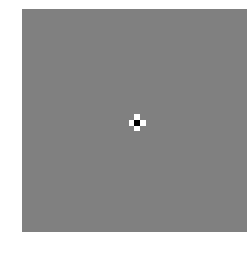

In [16]:
imageplot(S)

Update neighbor values.
For each neightbo $j$ of $i$, perform the update,
assuming the length of the edge between $j$ and $k$ is $W_j$.
$$ D_j \leftarrow \umin{k \sim j} D_k + W_j. $$

In [17]:
DNeigh = lambda D,k: extract1d(D,Neigh(j,k))
for j in J:
    dx = min(DNeigh(D,0), DNeigh(D,1))
    dy = min(DNeigh(D,2), DNeigh(D,3))
    u = ind2sub1(j)
    w = extract1d(W,j);
    D[u[0],u[1]] = min(dx + w, dy + w)

__Exercise 1__

Implement the Dijkstra algorithm by iterating these step while the
stack |I| is non empty.
Display from time to time the front that propagates.

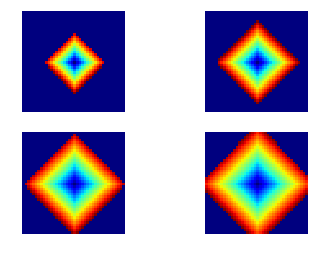

In [18]:
D = solutions.exo1(x0,W)

In [19]:
## Insert your code here.

Display the geodesic distance map using a cosine modulation to make the
level set appears more clearly.

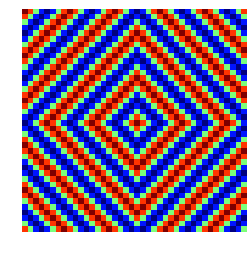

In [20]:
displ = lambda D: cos(2*pi*5*D/max(D.flatten()) )
imageplot(displ(D))
set_cmap('jet')

Fast Marching
-------------
The Dijstra algorithm suffers from a strong metrization problem, and it
actually computes the $\ell^1$ distance on the grid.


The Fast Marching algorithm replace the graph update by a local
resolution of the Eikonal equation. This reduces significantly the grid
bias, and can be shown to converge to the underlying geodesic distance
when the grid step size tends to zero.


Over a continuous domain, the distance map $D(x)$ to a set of seed
points $ \Ss $ is the unique solution in the viscosity sense
$$ \forall x \notin \Ss, \quad \norm{\nabla D(x)} = W(x)
      \qandq
    \forall y \in \Ss, \quad D(y) = 0. $$


The equation is then discretized on a grid of $n \times n$ pixel, and a
solution $ (D_{k,\ell})_{k,\ell=1}^n \in \RR^{n \times n} $ is found by using
an upwind finite difference approximation, that is faithful to the
viscosity solution
$$ \forall (k,\ell) \notin \tilde \Ss,  \quad
     \norm{ (\nabla D)_{k,\ell} } = W_{k,\ell}$
  \qandq
  \forall (k,\ell) \notin \tilde \Ss, \quad D_{k,\ell}=0,
$$
where $\tilde \Ss$ is the set of discrete starting points (defined here
by |x0|).


To be consisten with the viscosity solution, one needs to use a
non-linear upwind gradient derivative. This corresponds to computing
the norm of the gradient as
$$ \norm{ (\nabla D)_{k,\ell} }^2 =
      \max( D_{k+1,\ell}-D_{k,\ell}, D_{k-1,\ell}-D_{k,\ell}, 0 )^2 +
      \max( D_{k,\ell+1}-D_{k,\ell}, D_{k,\ell-1}-D_{k,\ell}, 0 )^2.
$$


A each step of the FM propagation, one update $ D_{k,\ell} \leftarrow d $
by solving the eikonal equation with respect to $D_{k,\ell}$ alone.
This is equivalent to solving the quadratic equation
$$ (d-d_x)^2 + (d-d_y)^2 = w^2 \qwhereq w=W_{k,\ell}. $$
and where
$$ d_x = \min(D_{k+1,\ell},D_{k-1,\ell}) \qandq
   d_y = \min(D_{k,\ell+1},D_{k,\ell-1}). $$


The update is thus defined as
$$
      d = \choice{
          \frac{d_x+d_y+ \sqrt{\De}}{2} \quad\text{when}\quad \De \geq 0, \\
          \min(d_x,d_y)+w \quad \text{otherwise.}$
      }$
      \qwhereq
      \De = 2 w^2 - (d_x-d_y)^2.
$$


Note that in the case where $\De<0$, one has to use the Dijkstra
update.


Once the Dijstra algorithm is implemented, the implementation of the Fast
Marching is trivial. It just corresponds to replacing the graph udpate

In [21]:
D[u[0],u[1]] = min(dx + w, dy + w)

by the eikonal update.

In [22]:
Delta = 2*w - (dx-dy)**2
if (Delta>=0):
    D[u[0],u[1]] = (dx + dy + sqrt(Delta))/ 2
else:
    D[u[0],u[1]] = min(dx + w, dy + w)

__Exercise 2__

Implement the Fast Marching algorithm.
Display from time to time the front that propagates.

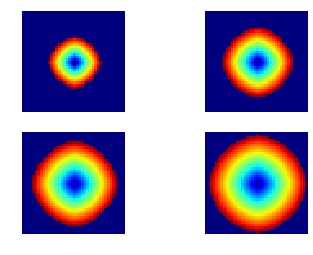

In [23]:
D = solutions.exo2(x0,W)

In [24]:
## Insert your code here.

Display the geodesic distance map using a cosine modulation to make the
level set appears more clearly.

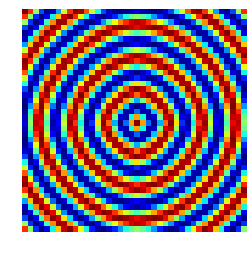

In [25]:
imageplot(displ(D))
set_cmap('jet')

Computation of Geodesic Paths
-----------------------------
We use a more complicated, non-constant metric, with a bump in the
middle.

In [26]:
n = 100
x = linspace(-1, 1, n)
[Y, X] = meshgrid(x, x)
sigma = .2
W = 1 + 8 * exp(-(X**2 + Y**2)/ (2*sigma**2))

Display it.

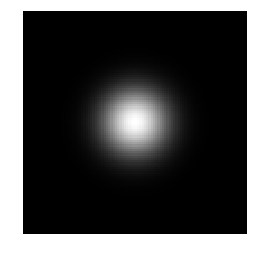

In [27]:
imageplot(W)

Starting points.

In [28]:
x0 = [round(.1*n), round(.1*n)]

__Exercise 3:__ 

Compute the distance map to these starting point using the FM algorithm. _Important:_ use symetric boundary conditions.

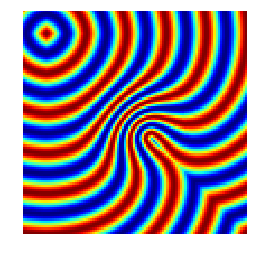

In [29]:
D = solutions.exo3(x0,W)

In [30]:
## Insert your code here.

Once the geodesic distance map to $\Ss$
has been computed, the geodesic curve between any point $x_1$ and $\Ss$
extracted through gradient descent
$$ \ga'(t) = - \eta_t \nabla D(\ga(t)) \qandq \ga(0)=x_1 $$
where $\eta_t>0$ controls the parameterization speed of the resulting
curve.


To obtain unit speed parameterization, one can use $\eta_t =
\norm{\nabla D(\ga(t))}^{-1}$ (one need to be careful when
$\ga$ approaches $\Ss$ since $D$ is not smooth on $\Ss$).


Compute the gradient $G_0(x) = \nabla D(x) \in \RR^2$ of the distance map.
Use centered differences.

In [31]:
G0 = grad(D)

Normalize the gradient to obtained $G(x) = G_0(x)/\norm{G_0(x)}$, in order to have unit speed geodesic curve (parameterized
by arc length).

In [32]:
d = sqrt(sum(G0**2, axis=2))
U = zeros((n,n,2))
U[:,:,0] = d
U[:,:,1] = d
G = G0 / U

The geodesic is then numerically computed using a discretized gradient
descent, which defines a discret curve $ (\ga_k)_k $ using
$$ \ga_{k+1} = \ga_k - \tau G(\ga_k) $$
where $\ga_k \in \RR^2$ is an approximation of $\ga(t)$ at time
$t=k\tau$, and the step size $\tau>0$ should be small enough.


Step size $\tau$ for the gradient descent.

In [33]:
tau = .8

Initialize the path with the ending point.

In [34]:
x1 = round(.9*n) + 1j*round(.88*n)
gamma = [x1]

Define a shortcut to interpolate $G$ at a 2-D points.
_Warning:_ the |interp2| switches the role of the axis ...

In [35]:
Geval = lambda G,x: bilinear_interpolate(G[:,:,0], imag(x), real(x) ) + 1j * bilinear_interpolate(G[:,:,1],imag(x), real(x))

Compute the gradient at the last point in the path, using interpolation.

In [36]:
g = Geval(G, gamma[-1] )

Perform the descent and add the new point to the path.

In [37]:
gamma.append( gamma[-1] - tau*g )

__Exercise 4__

Perform the full geodesic path extraction by iterating the gradient
descent. You must be very careful when the path become close to
$x_0$, because the distance function is not differentiable at this
point. You must stop the iteration when the path is close to $x_0$.

In [38]:
gamma = solutions.exo4(tau,x0,x1,G)

In [39]:
## Insert your code here.

Display the geodesic curve.

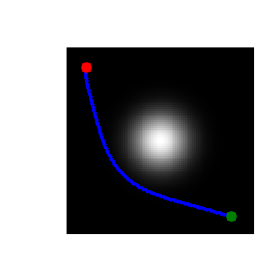

In [40]:
clf
imageplot(W) 
set_cmap('gray')
h = plot(imag(gamma), real(gamma), '.b', linewidth=2)
h = plot(x0[1], x0[0], '.r', markersize=20)
h = plot(imag(x1), real(x1), '.g', markersize=20)